# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [31]:
# code here
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [32]:
# code here
transform = transforms.Compose([transforms.ToTensor(),])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
print(trainset.data.shape)
print(testset.data.shape)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device= 'cuda' if torch.cuda.is_available() else 'cpu'

(50000, 32, 32, 3)
(10000, 32, 32, 3)


torch.Size([100, 3, 32, 32])
torch.Size([100])


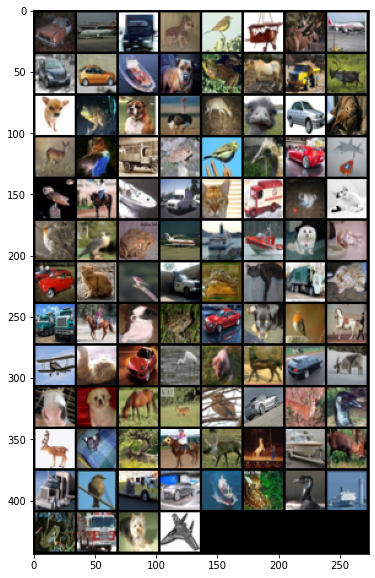

In [34]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [35]:
class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super(MLPAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3072),
            nn.Unflatten(1,(3,32,32))
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

class ComboAutoEncoder(nn.Module):
    def __init__(self):
        super(ComboAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(2048, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded
    
mlpautoencoder = MLPAutoEncoder()
mlpautoencoder = mlpautoencoder.to(device)

comboautoencoder = ComboAutoEncoder()
comboautoencoder = comboautoencoder.to(device)

cnnautoencoder = CNNAutoEncoder()
cnnautoencoder = cnnautoencoder.to(device)

In [36]:
# # sample code for a autoencoder:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # Input size: [batch, 3, 32, 32]
#         # Output size: [batch, 3, 32, 32]
#         # Representation size: 3072
#         # Number of Layers for encoder: 1
#         # Number of Layers for decoder: 1
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
#             nn.ReLU(),
#             nn.Flatten(), # 12x16x16 -> 3072
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
#             nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
#             nn.Sigmoid(),
#         )
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded


### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

epoch [1/5], loss:0.0224, time taken:12.32
epoch [2/5], loss:0.0189, time taken:18.42
epoch [3/5], loss:0.0166, time taken:16.31
epoch [4/5], loss:0.0178, time taken:10.83
epoch [5/5], loss:0.0172, time taken:10.19
MLPAutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(3, 32, 32))
  )
)
model size: 26.084MB


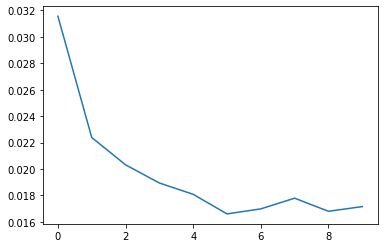

epoch [1/5], loss:0.0447, time taken:11.62
epoch [2/5], loss:0.0441, time taken:11.75
epoch [3/5], loss:0.0477, time taken:11.94
epoch [4/5], loss:0.0227, time taken:14.18
epoch [5/5], loss:0.0159, time taken:11.91
ComboAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=32, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=2048, bias=True)
    

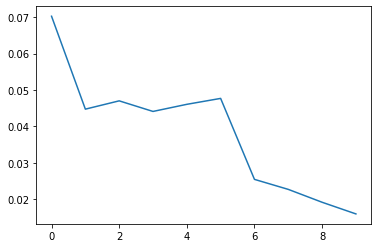

epoch [1/5], loss:0.0112, time taken:11.61
epoch [2/5], loss:0.0095, time taken:11.77
epoch [3/5], loss:0.0078, time taken:15.39
epoch [4/5], loss:0.0075, time taken:11.62
epoch [5/5], loss:0.0057, time taken:11.69
CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspos

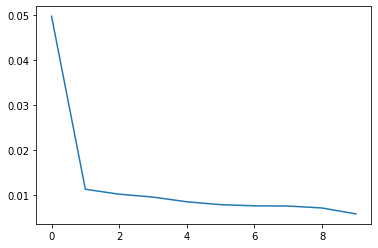

In [37]:
# code here

for autoencoder in [mlpautoencoder,comboautoencoder,cnnautoencoder]:

  autoencoder.train()

  criterion = nn.MSELoss()

  optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

  num_epochs = 5

  losses = []

  for epoch in range(num_epochs):
      running_loss = 0
      t0=time.time()
      for data in trainloader:
          img, _ = data
          img = img.to(device)
          img = Variable(img)

          encoded,decoded = autoencoder(img)
          loss = criterion(decoded, img)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      lossval = running_loss/len(trainloader)
      losses.append(lossval)

      print('epoch [{}/{}], loss:{:.4f}, time taken:{:.2f}'.format(epoch+1, num_epochs, loss.item(), time.time()-t0))
      losses.append(loss.item())
  print(autoencoder)
  param_size = 0
  for param in autoencoder.parameters():
    param_size += param.nelement() * param.element_size()
  buffer_size = 0

  size_all_mb = (param_size) / 1024**2
  print('model size: {:.3f}MB'.format(size_all_mb))
  plt.plot(losses)
  plt.show()




    



GroundTruth:    cat  ship  ship plane  frog


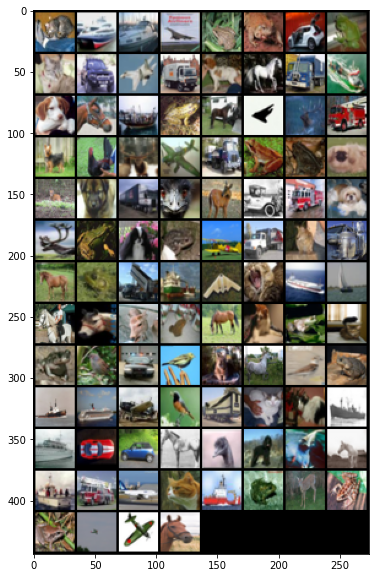

Reconstructed image for MLP


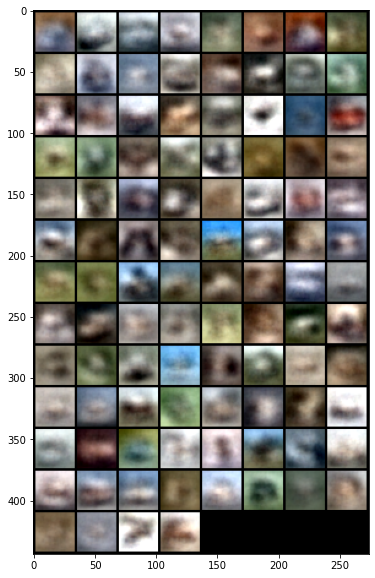

Reconstructed image for Combo


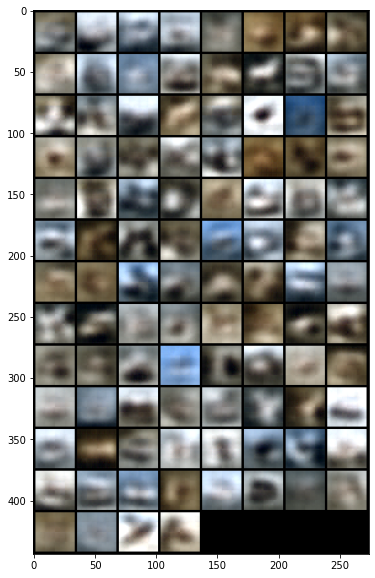

Reconstructed image for CNN


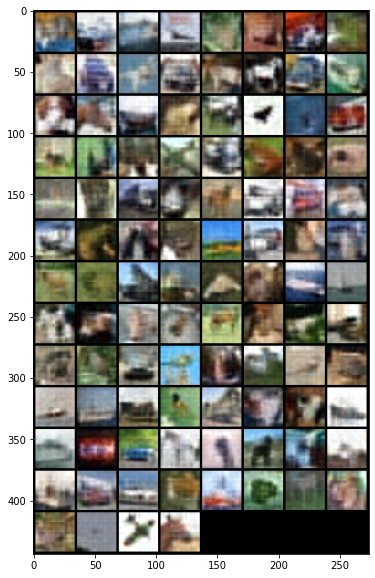

In [38]:
# Utilize the following code
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images.cpu()))

images = Variable(images)

print("Reconstructed image for MLP")
decoded_imgs = mlpautoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

print("Reconstructed image for Combo")
decoded_imgs = comboautoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

print("Reconstructed image for CNN")
decoded_imgs = cnnautoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [40]:
# code and analysis here

class CNNAutoEncoder10(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder10, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(2048, 10),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10,2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

class CNNAutoEncoder32(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder32, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(2048, 32),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32,2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

class CNNAutoEncoder100(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder100, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(2048, 100),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(100,2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

class CNNAutoEncoder1000(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder1000, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(2048, 1000),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1000,2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

autoencoder10=CNNAutoEncoder10()
autoencoder10 = autoencoder10.to(device)
autoencoder32=CNNAutoEncoder32()
autoencoder32 = autoencoder32.to(device)
autoencoder100=CNNAutoEncoder100()
autoencoder100 = autoencoder100.to(device)
autoencoder1000=CNNAutoEncoder1000()
autoencoder1000 = autoencoder1000.to(device)



epoch [1/5], loss:0.0438, time taken:11.96
epoch [2/5], loss:0.0293, time taken:11.84
epoch [3/5], loss:0.0272, time taken:11.77
epoch [4/5], loss:0.0268, time taken:11.91
epoch [5/5], loss:0.0303, time taken:11.86
CNNAutoEncoder10(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=10, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=2048, bias=True)
    

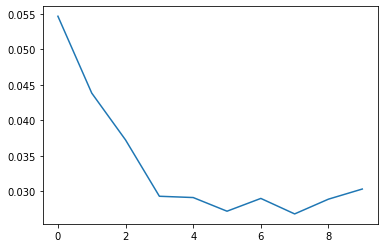

epoch [1/5], loss:0.0242, time taken:11.80
epoch [2/5], loss:0.0179, time taken:12.06
epoch [3/5], loss:0.0164, time taken:12.41
epoch [4/5], loss:0.0168, time taken:11.97
epoch [5/5], loss:0.0165, time taken:17.66
CNNAutoEncoder32(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=32, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=2048, bias=True)
    

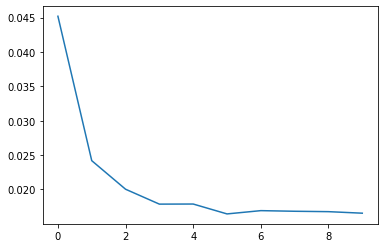

epoch [1/5], loss:0.0384, time taken:14.19
epoch [2/5], loss:0.0367, time taken:12.03
epoch [3/5], loss:0.0373, time taken:12.10
epoch [4/5], loss:0.0366, time taken:11.91
epoch [5/5], loss:0.0356, time taken:12.00
CNNAutoEncoder100(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=100, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
 

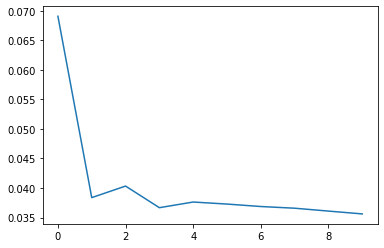

epoch [1/5], loss:0.0152, time taken:13.58
epoch [2/5], loss:0.0122, time taken:14.80
epoch [3/5], loss:0.0100, time taken:12.54
epoch [4/5], loss:0.0105, time taken:12.55
epoch [5/5], loss:0.0078, time taken:12.60
CNNAutoEncoder1000(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=1000, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=2048, bias=True

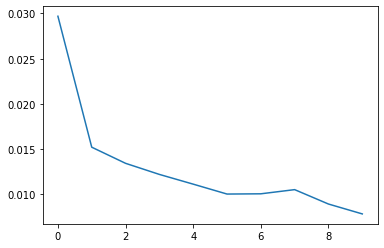

In [41]:
for autoencoder in [autoencoder10,autoencoder32,autoencoder100,autoencoder1000]:

  autoencoder.train()

  criterion = nn.MSELoss()

  optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

  num_epochs = 5

  losses = []

  for epoch in range(num_epochs):
      running_loss = 0
      t0=time.time()
      for data in trainloader:
          img, _ = data
          img = img.to(device)
          img = Variable(img)
          
          encoded,decoded = autoencoder(img)
          loss = criterion(decoded, img)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      
      lossval = running_loss/len(trainloader)
      losses.append(lossval)

      print('epoch [{}/{}], loss:{:.4f}, time taken:{:.2f}'.format(epoch+1, num_epochs, loss.item(), time.time()-t0))
      losses.append(loss.item())
  print(autoencoder)
  param_size = 0
  for param in autoencoder.parameters():
    param_size += param.nelement() * param.element_size()
  buffer_size = 0

  size_all_mb = (param_size) / 1024**2
  print('model size: {:.3f}MB'.format(size_all_mb))
  plt.plot(losses)
  plt.show()


GroundTruth:    cat  ship  ship plane  frog


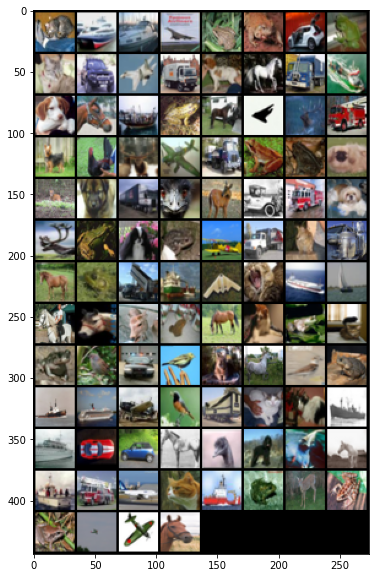

Reconstructed image for rep size = 10


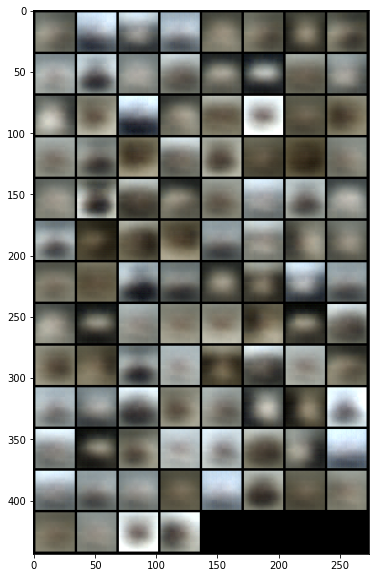

Reconstructed image for rep size = 32


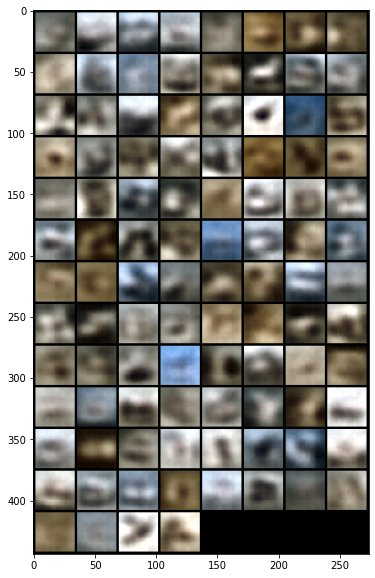

Reconstructed image for rep size = 100


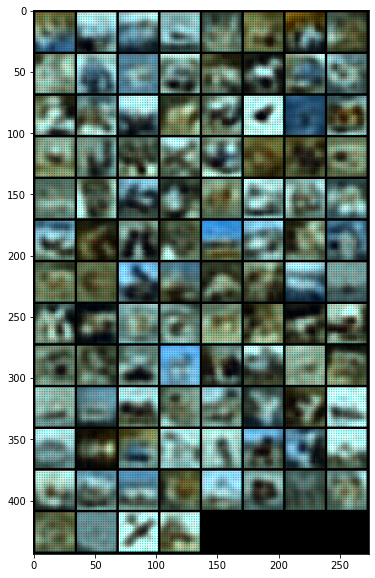

Reconstructed image for rep size = 1000


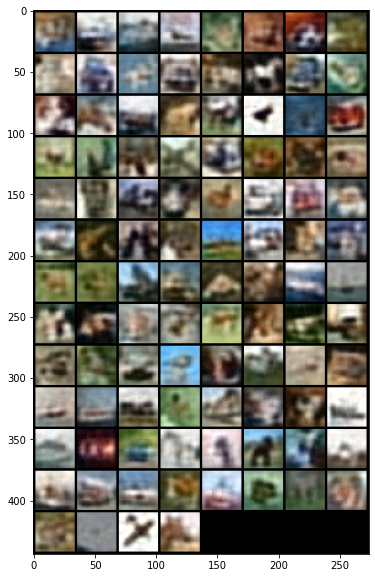

In [42]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images.cpu()))

images = Variable(images)

print("Reconstructed image for rep size = 10")
decoded_imgs = autoencoder10(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

print("Reconstructed image for rep size = 32")
decoded_imgs = autoencoder32(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

print("Reconstructed image for rep size = 100")
decoded_imgs = autoencoder100(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

print("Reconstructed image for rep size = 1000")
decoded_imgs = autoencoder1000(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [43]:
# code and analysis here
class CNNAutoEncoder1(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Flatten(), # 12x16x16 -> 3072
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
class CNNAutoEncoder3(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1), # 12x16x16 -> 24x8x8
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1), # 24x8x8 -> 48x4x4
            nn.ReLU(),
            nn.Flatten(), # 48x4x4 -> 768
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (48, 4, 4)), # 768 -> 48x4x4
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # 48x4x4 -> 24x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), # 24x8x8 -> 12x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
class CNNAutoEncoder5(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder5, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1), # 12x16x16 -> 24x8x8
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1), # 24x8x8 -> 48x4x4
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1), # 48x4x4 -> 96x2x2
            nn.ReLU(),
            nn.Conv2d(96, 192, 4, stride=2, padding=1), # 96x2x2 -> 192x1x1
            nn.ReLU(),
            nn.Flatten(), # 192x1x1 -> 192
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (192, 1, 1)), # 192 -> 192x1x1
            nn.ConvTranspose2d(192, 96, 4, stride=2, padding=1), # 192x1x1 -> 96x2x2
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), # 96x2x2 -> 48x4x4
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # 48x4x4 -> 24x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), # 24x8x8 -> 12x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder1=CNNAutoEncoder1()
autoencoder1 = autoencoder1.to(device)
autoencoder3=CNNAutoEncoder3()
autoencoder3 = autoencoder3.to(device)
autoencoder5=CNNAutoEncoder5()
autoencoder5 = autoencoder5.to(device)

epoch [1/5], loss:0.0045, time taken:9.07
epoch [2/5], loss:0.0025, time taken:8.43
epoch [3/5], loss:0.0018, time taken:9.06
epoch [4/5], loss:0.0015, time taken:9.08
epoch [5/5], loss:0.0012, time taken:8.79
CNNAutoEncoder1(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(12, 16, 16))
    (1): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Sigmoid()
  )
)
model size: 0.004MB


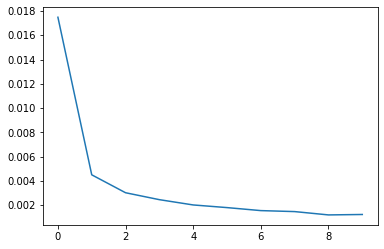

epoch [1/5], loss:0.0118, time taken:9.90
epoch [2/5], loss:0.0082, time taken:10.26
epoch [3/5], loss:0.0074, time taken:10.11
epoch [4/5], loss:0.0065, time taken:10.16
epoch [5/5], loss:0.0060, time taken:10.11
CNNAutoEncoder3(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(48, 4, 4))
    (1): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): Sigmoid()
  )
)
model size: 0.181MB


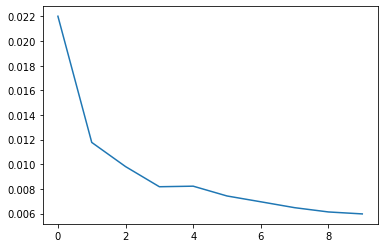

epoch [1/5], loss:0.0331, time taken:12.62
epoch [2/5], loss:0.0251, time taken:12.70
epoch [3/5], loss:0.0238, time taken:12.45
epoch [4/5], loss:0.0222, time taken:13.12
epoch [5/5], loss:0.0198, time taken:12.49
CNNAutoEncoder5(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(192, 1, 1))
    (1): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride

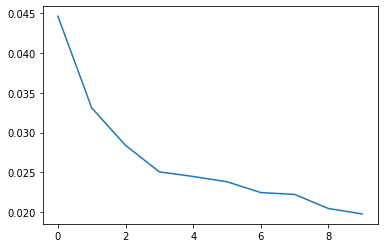

In [44]:
for autoencoder in [autoencoder1,autoencoder3,autoencoder5]:

  autoencoder.train()

  criterion = nn.MSELoss()

  optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

  num_epochs = 5

  losses = []

  for epoch in range(num_epochs):
      running_loss = 0
      t0=time.time()
      for data in trainloader:
          img, _ = data
          img = img.to(device)
          img = Variable(img)
          
          encoded,decoded = autoencoder(img)
          loss = criterion(decoded, img)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      
      lossval = running_loss/len(trainloader)
      losses.append(lossval)

      print('epoch [{}/{}], loss:{:.4f}, time taken:{:.2f}'.format(epoch+1, num_epochs, loss.item(), time.time()-t0))
      losses.append(loss.item())
  print(autoencoder)
  param_size = 0
  for param in autoencoder.parameters():
    param_size += param.nelement() * param.element_size()
  buffer_size = 0

  size_all_mb = (param_size) / 1024**2
  print('model size: {:.3f}MB'.format(size_all_mb))
  plt.plot(losses)
  plt.show()

GroundTruth:    cat  ship  ship plane  frog


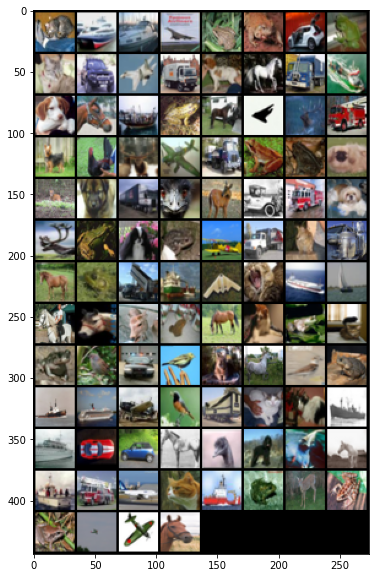

Reconstructed image for 1 layer


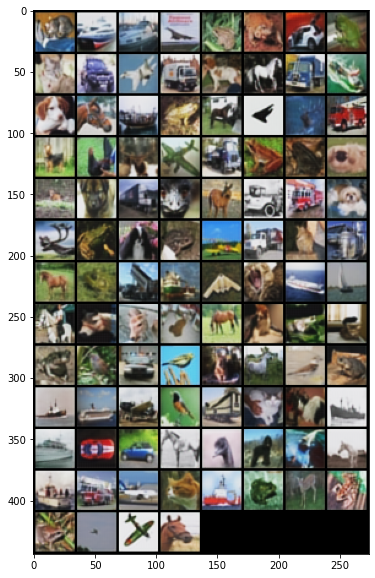

Reconstructed image for 3 layers


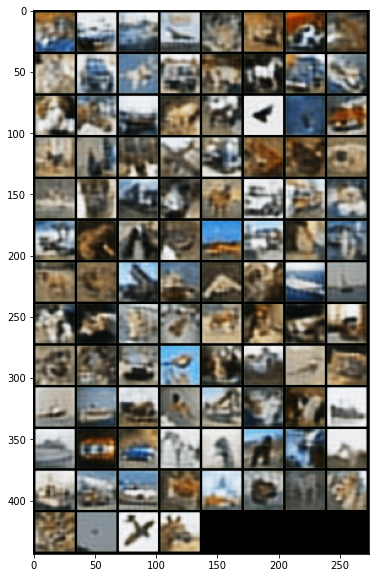

Reconstructed image for 5 layers


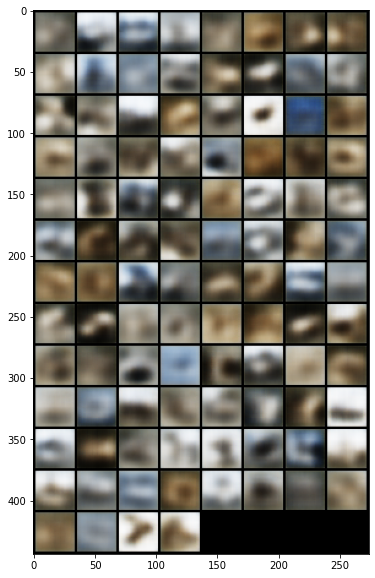

In [45]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images.cpu()))

images = Variable(images)

print("Reconstructed image for 1 layer")
decoded_imgs = autoencoder1(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

print("Reconstructed image for 3 layers")
decoded_imgs = autoencoder3(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

print("Reconstructed image for 5 layers")
decoded_imgs = autoencoder5(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

`An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”.`

`The autoencoder is composed of two parts: an encoder and a decoder. The encoder compresses the input into a lower-dimensional representation, and the decoder reconstructs the input from the representation. The encoder and decoder are connected by their weights, so that the decoder learns to reconstruct the input from the compressed representation. The network is trained to minimize the reconstruction error, so that the representation it learns is useful for some task.`

`It is different from PCA because PCA is a linear dimensionality reduction technique, whereas autoencoders are non-linear.` 

`From our experiments we observe that:`
- ` 1. CNNs are better than MLPs for image processing tasks.`
- `2. The representation size of the encoder has a significant impact on the reconstruction quality. When the representation size is too small, the auto-encoder is unable to learn a good representation of the input data. When the representation size is too large, the auto-encoder is prone to overfitting.`
- `3. The number of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. It appears that when the number of layers increases, the reconstruction quality improves. However, the reconstruction quality may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited.`

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [48]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [49]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [50]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [51]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."